# 01 Prepare Test Data

Ryan E Lima [](https://orcid.org/0000-0002-5352-7215)

Text description

In [1]:
## Install libraries if not installed
#!pip install geopandas 

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
from matplotlib import colors
from skimage import feature, measure, morphology
from skimage.draw import line
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import euclidean
from math import atan2, degrees
from skimage.measure import approximate_polygon, find_contours


In [17]:
DEM_URL = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/historical/n36w112/USGS_13_n36w112_20240614.tif'
study_area_shapefile_path = 'Data/Vectors/LakeMaryStudyArea_Bound.shp'


In [29]:
# Load the DEM
with rasterio.open(DEM_URL) as src:
    DEM = src.read(1)  # Load the DEM as a NumPy array
    transform = src.transform
    crs = src.crs
    dem_bounds = src.bounds
    nodata = src.nodata  # Capture the nodata value
    print("DEM bounds:", dem_bounds)
    print("DEM nodata value:", nodata)

DEM bounds: BoundingBox(left=-112.00055555619338, bottom=34.9994444441067, right=-110.99944444400529, top=36.000555556294785)
DEM nodata value: -999999.0

In [30]:
study_area = gpd.read_file(study_area_shapefile_path)


In [33]:
# Reproject the shapefile to match DEM CRS
study_area = study_area.to_crs(crs)
print("Shapefile bounds:", study_area.total_bounds)

Shapefile bounds: [-111.62501107   35.12500537 -111.56251105   35.18750538]

In [34]:
# Clip the DEM to the shapefile geometry
geoms = study_area.geometry.values  # Get the geometries from the GeoDataFrame
geoms = [geom.__geo_interface__ for geom in geoms]  # Convert to GeoJSON format

In [35]:
with rasterio.open(DEM_URL) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta

In [36]:
# Mask the nodata values
out_image = np.ma.masked_equal(out_image, nodata)

In [37]:
# Check DEM range
print("DEM min:", np.min(out_image))
print("DEM max:", np.max(out_image))

DEM min: 1998.0142
DEM max: 2179.7163

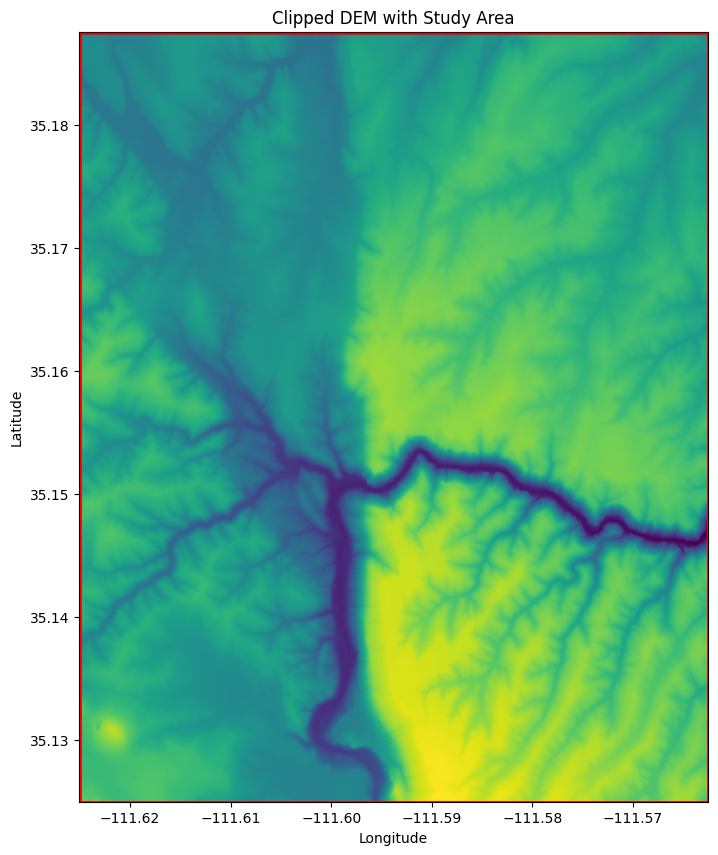

In [40]:
# Normalize the DEM values for better visualization
norm = colors.Normalize(vmin=np.min(out_image), vmax=np.max(out_image))

# Plot the clipped DEM
fig, ax = plt.subplots(figsize=(10, 10))
show(out_image, transform=out_transform, cmap='viridis', ax=ax, norm=norm)

# Overlay the shapefile
study_area.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

plt.title('Clipped DEM with Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [42]:
# Update metadata to reflect new dimensions and transform
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

In [44]:
# Save the clipped DEM
output_path = "Data/Rasters/clipped_dem.tif"
with rasterio.open(output_path, 'w', **out_meta) as dest:
    # Write the first band (use out_image[0] since it has shape (1, height, width))
    dest.write(out_image[0].filled(nodata), 1)  # Fill the masked values with nodata
print(f"Clipped DEM saved to {output_path}")

Clipped DEM saved to Data/Rasters/clipped_dem.tif

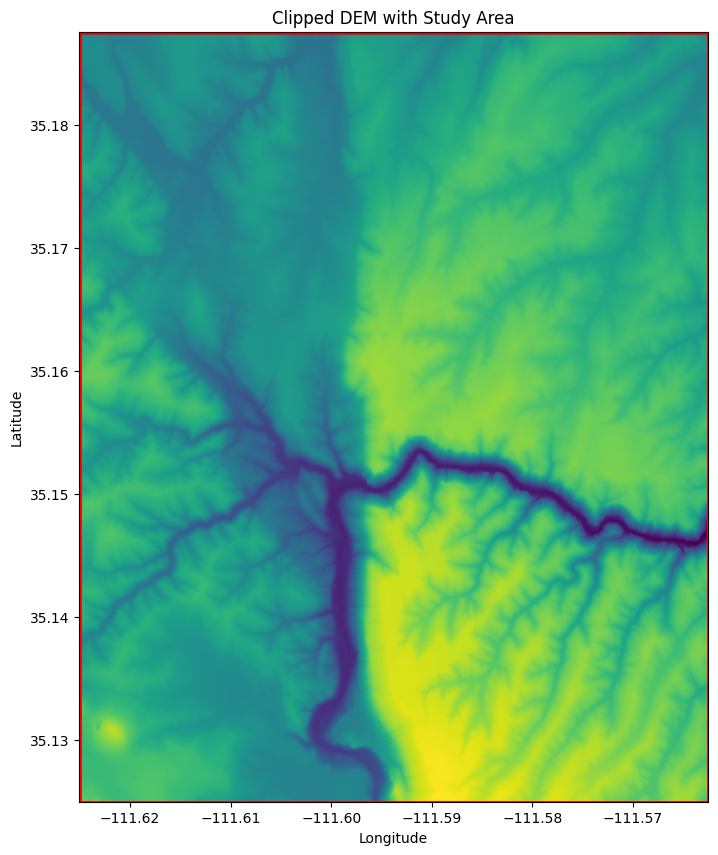

In [46]:
DEM10m = out_image

# Optionally, plot the clipped DEM
fig, ax = plt.subplots(figsize=(10, 10))
norm = colors.Normalize(vmin=np.min(out_image), vmax=np.max(out_image))
show(DEM10m, transform=out_transform, cmap='viridis', ax=ax, norm=norm)
study_area.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
plt.title('Clipped DEM with Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [54]:
# Load Faults

faults_URL = 'Data/Vectors/Faults.shp'
faults = gpd.read_file(faults_URL)
faults = faults.to_crs(crs)
print("Shapefile bounds:", faults.total_bounds)

# Load Contacts

contacts_URL = 'Data/Vectors/Contacts.shp'
contacts = gpd.read_file(contacts_URL)
contacts = contacts.to_crs(crs)
print("Shapefile bounds:", contacts.total_bounds)

Shapefile bounds: [-111.62501105   35.12500939 -111.59149268   35.18750927]
Shapefile bounds: [-111.62501107   35.12500543 -111.56251097   35.18750938]

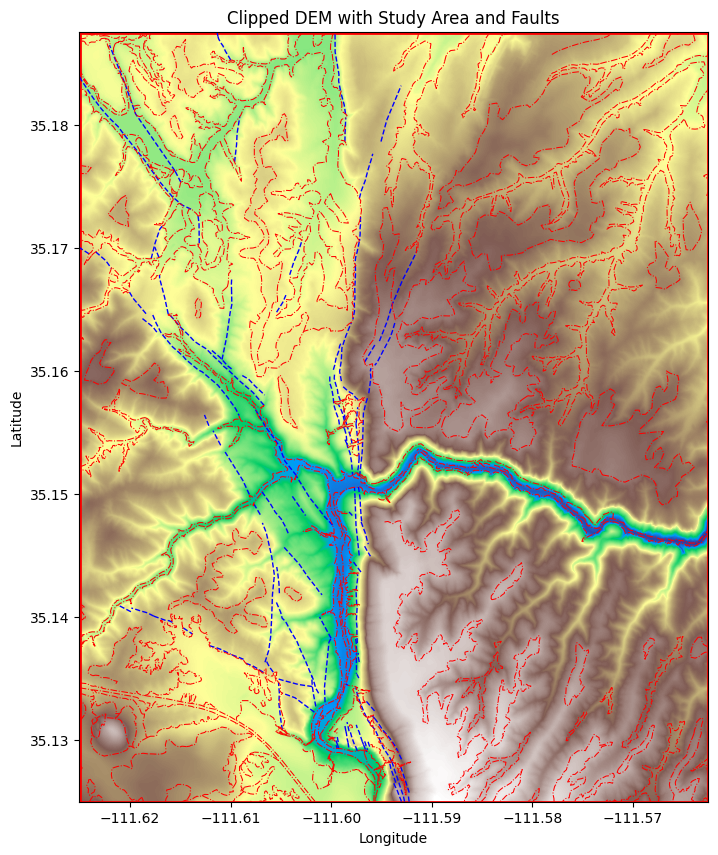

In [58]:
# Plot the clipped DEM, study area, and faults
fig, ax = plt.subplots(figsize=(10, 10))

# Normalize the DEM values for better visualization
norm = colors.Normalize(vmin=np.min(out_image), vmax=np.max(out_image))

# Plot the DEM
show(out_image, transform=out_transform, cmap='terrain', ax=ax, norm=norm)

# Plot the study area boundary
study_area.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Plot the faults
faults.plot(ax=ax, edgecolor='blue', linewidth=1, linestyle='--')
contacts.plot(ax=ax, edgecolor = 'red', linewidth = 0.75, linestyle='-.')

plt.title('Clipped DEM with Study Area and Faults')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# create multiple hillshades 

In [72]:
# Function to apply Gaussian smoothing and Canny edge detection
def apply_canny_filter(dem_data, mask, sigma=2.0, gthr_low=10, gthr_high=30):
    # Step 1: Replace masked values (nodata) with the median of the valid data
    filled_dem_data = dem_data.filled(np.median(dem_data))  # Fill masked areas with the median
    
    # Step 2: Apply Gaussian smoothing
    smoothed_dem = gaussian_filter(filled_dem_data, sigma=sigma)
    
    # Step 3: Reapply the mask after smoothing (keep the masked regions as nodata)
    smoothed_dem = np.ma.masked_where(mask, smoothed_dem)  # Reapply the mask
    
    # Step 4: Apply Canny edge detection with adjusted thresholds (on the unmasked regions)
    edges = feature.canny(smoothed_dem, low_threshold=gthr_low, high_threshold=gthr_high)
    
    # Return both smoothed DEM and detected edges for visualization
    return smoothed_dem, edges

In [82]:
# Example parameters for the Canny filter
sigma = 1.0
gthr_low = 3
gthr_high = 10

# Ensure dem_data is 2D and get the mask for nodata values
dem_data = out_image[0] if out_image.ndim > 2 else out_image  # Adjust for possible 3D array
mask = dem_data.mask  # Extract the mask from the masked array

# Apply the Canny filter
smoothed_dem, edges = apply_canny_filter(dem_data, mask, sigma=sigma, gthr_low=gthr_low, gthr_high=gthr_high)

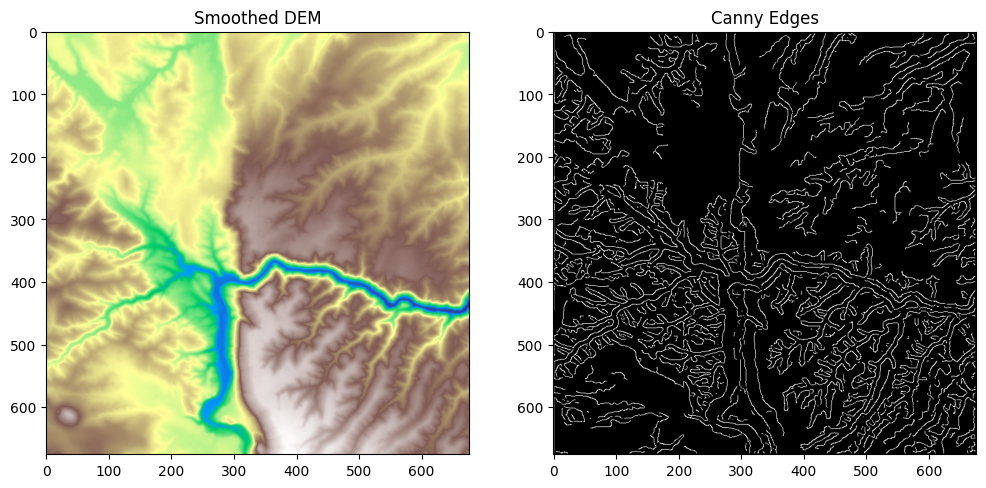

In [83]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot smoothed DEM
ax[0].imshow(smoothed_dem, cmap='terrain')
ax[0].set_title('Smoothed DEM')

# Plot edges
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Canny Edges')


plt.show()